In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

#### Khởi tạo tham số

#### batch_size = 200 
input_size = 160
model_name = "mobilenet_V2" 
version =  5
initial_epochs = 20
base_learning_rate = 0.0001 

In [4]:
path_colab_drive = '/content/drive/MyDrive/Colab_Notebooks/Fruit_classificaton'

In [ ]:
!cp f'{path_colab_drive}/data/data_split.zip' /content/data_split.zip
!unzip /content/data_split.zip -d /content/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/data_split/train/Tomatoes/Tamotoes001443.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001444.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001445.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001446.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001447.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001448.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001449.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001450.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001451.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001452.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001453.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001454.png  
  inflating: /content/data_split/train/Tomatoes/Tamotoes001455.png  
  inflating: /content/data_split/train/Tomatoe

## Xử lý ảnh: đưa ảnh về đúng kích thước (160, 160)

#### train_dir = '/content/data_split/train'
validation_dir = test_dir = '/content/data_split/val'

BATCH_SIZE = batch_size
IMG_SIZE = (input_size, input_size)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
4
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = test_dataset.class_names

### Bộ dữ liệu phân loại các loại quả quả

#### class_names = train_dataset.class_names
print("Các loại hoa quả là: ", class_names)
num_classes = len(class_names)
print("Số lượng class: ", num_classes)

#### plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Tiếp tục xử lý ảnh như: xoay, làm nhiễu,... 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

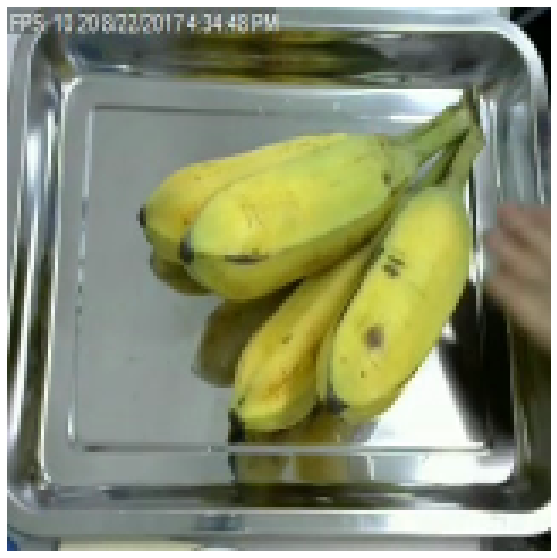

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomContrast(1),
  tf.keras.layers.experimental.preprocessing.RandomRotation((-1, 0.5)),
  tf.keras.layers.experimental.preprocessing.RandomCrop(160,160),
  tf.keras.layers.GaussianNoise(0.2)
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

## Xây dựng mô hình

### Pretrained

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
model_type = tf.keras.applications.MobileNetV2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = model_type(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(200, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(200, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, name='predict')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(200, 15)


### Mô hình 

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE, name='image_tensor')
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name=model_name)

## Huấn luyện

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()
print(f"Number of trainable variables: {len(model.trainable_variables)}")

Model: "mobilenet_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_tensor (InputLayer)   [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                      

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 13s 330ms/step - loss: 3.1604 - accuracy: 0.0647
initial loss: 3.16
initial accuracy: 0.06


In [ ]:
checkpoints_path = f"/content/drive/MyDrive/checkpoint/"

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True, mode='max', save_freq='epoch')
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', mode='max')

callbacks = [
    checkpoint_callback,
    early_stop_callback
]

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/20
205/205 [==============================] - 591s 3s/step - loss: 2.1707 - accuracy: 0.3242 - val_loss: 1.1517 - val_accuracy: 0.6742
Epoch 2/20
205/205 [==============================] - 589s 3s/step - loss: 1.1887 - accuracy: 0.6417 - val_loss: 0.6836 - val_accuracy: 0.8164
Epoch 3/20
205/205 [==============================] - 590s 3s/step - loss: 0.8621 - accuracy: 0.7485 - val_loss: 0.4966 - val_accuracy: 0.8706
Epoch 4/20
205/205 [==============================] - 608s 3s/step - loss: 0.7211 - accuracy: 0.7899 - val_loss: 0.3992 - val_accuracy: 0.9094
Epoch 5/20
205/205 [==============================] - 617s 3s/step - loss: 0.6373 - accuracy: 0.8123 - val_loss: 0.3324 - val_accuracy: 0.9254
Epoch 6/20
205/205 [==============================] - 592s 3s/step - loss: 0.5649 - accuracy: 0.8339 - val_loss: 0.2919 - val_accuracy: 0.9347
Epoch 7/20
205/205 [==============================] - 592s 3s/step - loss: 0.5261 - accuracy: 0.8454 - val_loss: 0.2535 - val_accuracy: 0.9449

### Lưu mô hình

In [ ]:
model.save(f'{path_colab_drive}/model/model.h5', include_optimizer=True)

# Dự đoán

In [5]:
model_path = f'{path_colab_drive}/model/model.h5'

In [6]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_class_img_with_img(img_path):
    class_names = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 
                   'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']

    # load model
    model = load_model(model_path)
    img_arr = cv2.imread(img_path)
    np_img = np.array(img_arr)

    # print(np_img.shape)
    image = np.expand_dims(cv2.resize(np.squeeze(np_img), (160, 160)), axis=0)

    predictions = model.predict(image)
    scores = tf.nn.sigmoid(predictions)
    pred_labels = np.argmax(scores, axis=-1)
    print(f"Fruit is {class_names[int(pred_labels)]}, score is {np.max(scores) * 100}%")
    cv2_imshow(image[0])
    # return class_names[int(pred_labels)]

1/1 [==============================] - 1s 738ms/step
Fruit is Apple, score is 89.82701301574707%


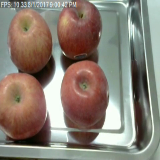

In [9]:
img_path = f'{path_colab_drive}/image_test/Apple 3.png'
predict_class_img_with_img(img_path)

In [1]:
import numpy

In [ ]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)